# 使用预训练的卷积神经网络

## 一、特征提取（feature extracting）

In [2]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

### 1. 不使用数据增强的快速特征提取

In [7]:
# 抽取特征

import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

root_dir = '/Users/wjj/datasets/kaggle/dogsvscats'
mini_samples_dir = os.path.join(root_dir, 'mini_samples')

train_dir = os.path.join(mini_samples_dir, 'train')
validation_dir = os.path.join(mini_samples_dir, 'validation')
test_dir = os.path.join(mini_samples_dir, 'test')

datagen = ImageDataGenerator(rescale=1.0/255)
batch_size = 20

def extract_features(image_dir, image_count):
    features = np.zeros(shape=(image_count, 4, 4, 512))
    labels = np.zeros(shape=(image_count))
    generator = datagen.flow_from_directory(
        image_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        begin_index = i*batch_size
        end_index = (i+1)*batch_size
        features[begin_index: end_index] = features_batch
        labels[begin_index: end_index] = labels_batch
        
        i += 1
        if i * batch_size >= image_count:
            break
    
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [10]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [17]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs = 30, batch_size = 20,
                    validation_data = (validation_features, validation_labels),
                    verbose=0)

In [15]:
import matplotlib.pyplot as plt

def draw_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

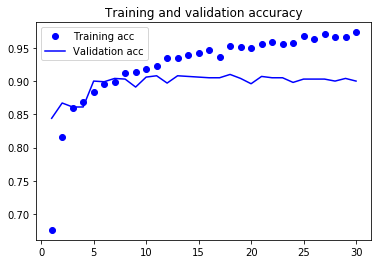

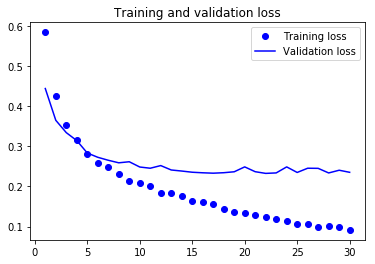

In [18]:
draw_history(history)

### 2. 使用数据增强的特征提取

In [19]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [20]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

conv_base.trainable = False

print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30
This is the number of trainable weights after freezing the conv base: 4


In [22]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch = 100,
    epochs = 30,
    validation_data=validation_generator,
    validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
draw_history(history)